In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad
import scipy as sci
import matplotlib.pyplot as plt

import os

In [2]:
import decoupler as dc
sc.settings.verbosity=0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.n_jobs=4
sc.settings.set_figure_params(dpi=400, facecolor="white", frameon=False, figsize=(15,15))
plt.rcParams['pdf.fonttype'] = 42
%matplotlib inline


In [3]:
sc.settings.figdir = "fig5"
scv.settings.figdir = "fig5"



In [4]:
#PATH = '/nfs/team298/ls34/disease_atlas/final_fb_adatas/ldata_fbs.h5ad.velo'
PATH = '/nfs/team298/ls34/fibroblast_atlas_paper/final_adatas/adata_velo_integrated_new.h5ad'
adata=sc.read_h5ad(PATH)
adata.obs.test12.value_counts()

test12
F1: Superficial                   11682
F7: Myofibroblast                 11037
F3: FRC-like                       7870
F2: Universal                      7202
F2/3: Perivascular                 5875
F6: Inflammatory myofibroblast     1790
Name: count, dtype: int64

In [247]:
# adata_store.write( '/nfs/team298/ls34/fibroblast_atlas_paper/final_adatas/adata_velo_integrated_new.h5ad')

# Filter

In [5]:
# RENAME = {'F2/3: Stroma_PPARG+': 'F2/3: Perivascular'}

# adata.obs["test2"]=adata.obs["test2"].map(RENAME).fillna(adata.obs["test2"])

In [6]:
# adata=adata[adata.obs["Patient_status"]!="Keloid"]
# adata=adata[~adata.obs["Patient_status"].str.startswith("Dupuytr")]

In [7]:
# 1) Count cells per sample
counts = adata.obs['sample_id'].value_counts()

# 2) Identify samples with fewer than 100 cells
small = counts[counts < 100].index.tolist()

# 3) Keep only cells whose sample_id is NOT in that small‐sample list
mask = ~adata.obs['sample_id'].isin(small)
adata = adata[mask].copy()

adata.obs.sample_id.value_counts()

sample_id
GSM5494685                    2481
GSM5494687                    2473
GSM5494686                    1988
GSM5494438                    1880
GSM5494690                    1373
                              ... 
GSM5348399                     107
GSM6532922                     107
GSM_patient2_Day3-Lesional     106
SRS6155880                     106
GSM5277189                     100
Name: count, Length: 108, dtype: int64

In [8]:
sc.pp.filter_genes(adata, min_counts=50)
adata.shape


(45456, 18923)

In [9]:
adata.obs.Site_status.value_counts()

Site_status
Lesional    44041
PostRx       1415
Name: count, dtype: int64

In [10]:
# normalize_per_cell

In [11]:
adata.obs.dataset_id.value_counts()

dataset_id
Keloid_Direder            10449
SSc_Ma                     7322
Prurigo_Patel              4310
Reynolds                   4269
Lyme_jiang                 2565
Luc_psoriasis              2256
Keloid_Shim                2237
Ma_psoriasis               1624
SSc_Tabib                  1516
Keloid_Deng                1516
Dupuytren's_Dobie          1104
Acne_Do                     874
Sarcoidosis_Damsky          869
AA_Greenleaf                847
Neurofibroma_Brousseau      718
Fascia1                     709
PSMorphoea                  493
Lupus_Dunlap                447
ImmunotherapyReaction       445
DRESS                       308
SCCarcinoma_Ji              289
AcralMM_Li                  162
AcralMM_Zhang               127
Name: count, dtype: int64

In [12]:
adata_store=adata.copy()
adata_store.shape

(45456, 18923)

# start here

In [326]:
adata=adata_store.copy()
adata.shape

(45456, 18923)

In [327]:
#adata=adata[adata.obs["dataset_id"]=="Luc_psoriasis"]
#adata=adata_store[adata_store.obs["dataset_id"]=="Keloid_Direder"]
N_NEIGHBOR=5
N_GENES=10_000
#N_PC=30
sc.pp.subsample(adata, 0.1)
USE_SCVI=True

In [328]:
adata=adata.copy()
adata

AnnData object with n_obs × n_vars = 4545 × 18923
    obs: 'sample_id', 'barcode', 'dataset_id', 'GSE', 'Site_status', 'Patient_status', 'DonorID', 'Location', 'Age', 'Sex', 'n_genes', 'OriginalAnnotation', 'Chemistry', 'lvl3_annotation', 'lvl2_annotation', 'lvl0_annotation', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'QC_hi', 'QC_mid', 'leiden_res0.2', 'Site_status_binary', 'atlas_status_reynolds', 'atlas_status', 'Site_status2', 'Patient_status2', 'Sex_original', 'leiden_res1', 'test', 'corefb_names', 'lvl3_annotation_uncert', 'lvl3_annotation_pred', 'leiden_res0.5', 'merged_annotations', 'test3', 'test4', 'test5', 'test6', 'leiden_res0.7', 'test7', 'lvl3_annotation_pred2', 'test8', 'test9', 'test10', 'test11', 'disease_category', 'macfb', 'macfb2', 'test12', 'test13', 'test14', 'test15', 'test

In [329]:
# adata = adata[(adata.obs["test12"].str.startswith("F1"))|
#               (adata.obs["test12"].str.startswith("F2"))|
#               (adata.obs["test12"].str.startswith("F6"))|
#               (adata.obs["test12"].str.startswith("F3"))|
#               (adata.obs["test12"].str.startswith("F7"))|
#                (adata.obs["test12"].str.startswith("F8"))
              
             
#              ]
# adata.obs.test12.value_counts()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

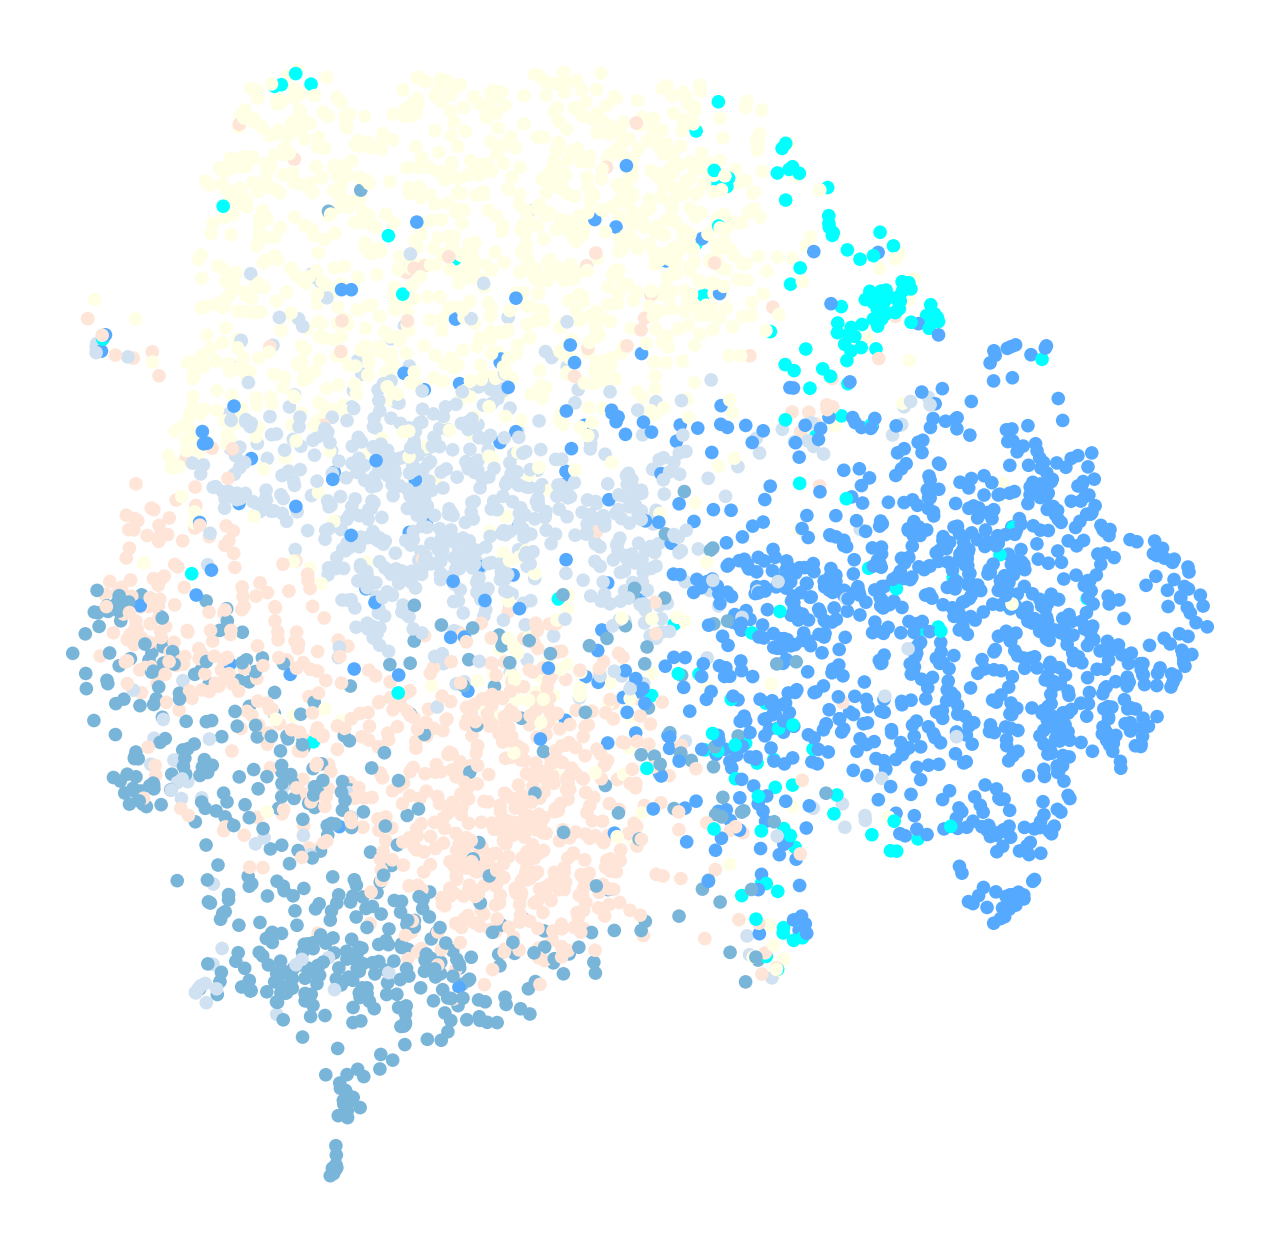

In [330]:
custom_colors = {'F1: Superficial': np.array([1.        , 1.        , 0.89803922, 1.        ]),
 'F1: EA-Regenerative': np.array([0.99607843, 0.80915033, 0.39607843, 1.        ]),
 'F2: Universal': np.array([0.81411765, 0.88392157, 0.94980392, 1.        ]),
 'F2/3: Perivascular': np.array([0.47294118, 0.71163399, 0.85071895, 1.        ]),
 'F3: FRC-like': np.array([0.99692426, 0.89619377, 0.84890427, 1.        ]),
 'F4: DS_DPEP1+': np.array([0.82745098, 0.93254902, 0.80313725, 1.        ]),
 'F4: TNN+COCH+': np.array([0.50196078, 0.79058824, 0.50143791, 1.        ]),
 'F4: DP_HHIP+': np.array([0.15294118, 0.56183007, 0.28313725, 1.        ]),
 'F5: RAMP1+':np.array([0.6177624 , 0.60213764, 0.78345252, 1.        ]),
 'F5: NGFR+': np.array([0.47320261, 0.43267974, 0.69934641, 1.        ]),
 'F6: Inflammatory myofibroblast': np.array([0., 1., 1., 1.]),
 'F7: Myofibroblast': np.array([0.33333333, 0.66666667, 1.        , 1.        ]),
 'F7: Fascia-like myofibroblast': np.array([0.95686275, 0.55686275, 0.74509804, 1.0]),
 'F_Fascia': np.array([0, 0, 0, 0.3])
                               }

adata.obs["test12"]=adata.obs["test12"].astype('category')
try:
    adata.uns["test12_colors"] = [custom_colors[cat] for cat in adata.obs["test12"].cat.categories]
except KeyError as e:
    print(f"Error: Missing color for category {e}")
sc.pl.umap(
    adata,
    color='test12',
    show=False,
    frameon=False,
    legend_loc=None, # "on data",
    legend_fontsize=5,
    s=150,
    title='',
    legend_fontoutline=2
)

 

# Run default

In [331]:
scv.pp.filter_and_normalize(adata, min_shared_cells=20, n_top_genes=N_GENES)  


Filtered out 12682 genes that are detected in less than 20 cells (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/home/jovyan/my-conda-envs/cellrank/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [332]:
adata.shape


(4545, 6241)

In [333]:
# sc.pp.highly_variable_genes(adata, 
#                             #min_mean=0.0125, 
#                           #  max_mean=3, 
#                           #  min_disp=0.5,
#                             batch_key="sample_id", 
#                             n_top_genes=N_GENES
#                             )


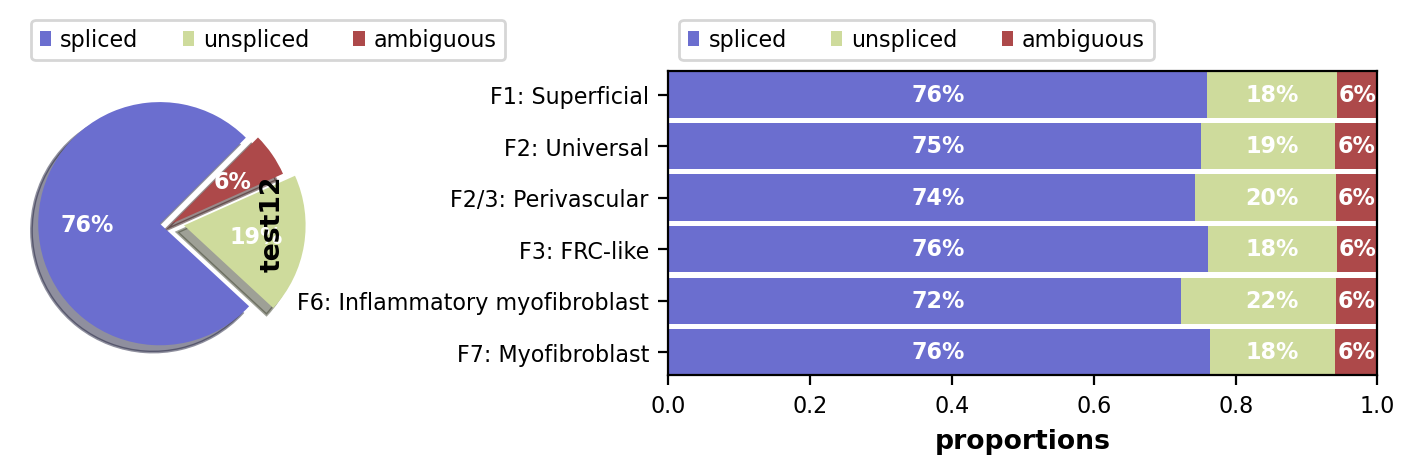

In [334]:
scv.pl.proportions(adata, groupby='test12')

In [335]:
if USE_SCVI:
    print("use scvi")
    scv.pp.neighbors(adata, 
                     n_neighbors=N_NEIGHBOR, 
                     use_rep = 'X_scvi'
                    )  #n_pcs = 10) #random_state=0)# use_rep = 'X_scvi')
    scv.pp.moments(adata,# n_pcs=None,
                   n_neighbors=N_NEIGHBOR,
                   use_rep='X_scvi'
                  )    # neighbor_key="n")
    #scv.pp.moments(adata, n_pcs=N_PC, n_neighbors=N_NEIGHBOR)
else:
    
    scv.pp.neighbors(adata, 
                     n_neighbors=N_NEIGHBOR, 
                     n_pcs = 30
                     #use_rep = 'X_scvi'
                    )  #n_pcs = 10) #random_state=0)# use_rep = 'X_scvi')
    scv.pp.moments(adata, n_pcs=30, n_neighbors=N_NEIGHBOR)

use scvi
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/tmp/ipykernel_23611/2868370242.py:3: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  scv.pp.neighbors(adata,


    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [336]:
import gc
gc.collect()


20082

In [337]:
0

0

In [338]:
adata.shape

(4545, 6241)

In [339]:
scv.tl.velocity(adata, mode='stochastic', groupby="test12")


computing velocities


/home/jovyan/my-conda-envs/cellrank/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))
/home/jovyan/my-conda-envs/cellrank/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))
/home/jovyan/my-conda-envs/cellrank/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single el

    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/home/jovyan/my-conda-envs/cellrank/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [ ]:
scv.tl.velocity_graph(adata)


computing velocity graph (using 1/26 cores)


In [ ]:
0

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=4  ,
    #save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=2  ,
   # save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 


# VELOCITY KERNEL

In [ ]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()


In [ ]:
# vk.plot_projection(color=['test13'], s=50, title='', save="_velocityembedding.pdf")
# plt.show()

In [1]:
9

9

In [ ]:
# #plt.rcParams['axes.grid'] = False
# vk.plot_projection(color=['test2'], s=50, title='', save="_velocityembedding.pdf")
# plt.show()

In [ ]:

# vk.plot_projection(color=['test12'], s=50, title='',
#                    linewidth=12,
#                   # save="fig5c_velocityembedding_nolabels.pdf",
#                    legend_loc="right")
# plt.show()

In [ ]:

vk.plot_projection(color=['test12'], s=50, title='',
                   linewidth=2,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()



In [ ]:

# vk.plot_projection(color=['test12'], s=50, title='',
#                    linewidth=2,
#                  #  save="fig5c_velocityembedding_nolabels.pdf",
#                    legend_loc=None, legend_fontoutline=2,
#                    legend_fontsize=20)
# plt.show()

In [ ]:

# vk.plot_projection(color=['test12'], s=50, title='',
#                    linewidth=3,
#                 #   save="fig5c_velocityembedding_nolabels2.pdf",
#                    legend_loc="on data",
#                   legend_fontoutline=2, legend_fontsize=20
#                   )
# plt.show()

In [ ]:

# vk.plot_projection(color=['test12'], s=50, title='',
#                    linewidth=3,
#                    #save="fig5c_velocityembedding_nolabels2.pdf", 
#                    legend_loc="right")
# plt.show()

In [ ]:
# vk.plot_projection(color=['test12'], s=50, title='',
#                    #save="fig5c_velocityembedding_nolabels.pdf",
#                    legend_loc="right")
# plt.show()

In [ ]:
# vk.plot_projection(color=['test2'], s=50, title='', save="_velocityembedding_nolabels.pdf", legend_loc="right",
#                   density=1, linewidth=2)
# plt.show()

In [ ]:
# vk.plot_projection(color=['test2'], s=50, title='', #save="_velocityembedding_nolabels.pdf",
                   
#                    legend_loc="right",
#                   density=1.2, linewidth=3)
# plt.show()

In [ ]:
ax = vk.plot_projection(color=['test12'], stream=False)


In [ ]:
# sc.pp.neighbors(adata,  n_neighbors=30, use_rep="X_scvi")

In [ ]:
# scv.pl.velocity_graph(adata, threshold=0.1, color='test2')


In [ ]:
scv.tl.velocity_pseudotime(adata)
                              # save="fig5a_pseudotime.pdf")
#plt.savefig("velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")


In [ ]:
# adata.uns['neighbors']['distances'] = adata.obsp['distances']
# adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
# scv.tl.paga(adata, groups='test12')

In [ ]:
scv.pl.scatter(adata, color="velocity_pseudotime", basis="umap",
               s=50,
               cmap="bwr")

#plt.savefig("fig5/fig5a_velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
# import sys
# !{sys.executable} -m pip install scipy==1.11.4

In [ ]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
scv.tl.paga(adata, groups='test12')

In [ ]:

scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )

In [ ]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck


In [ ]:

combined_kernel.plot_projection(color=['test12'], s=50, title='',
                   linewidth=2,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

# Re-do with reprocessing

In [ ]:
sc.tl.umap(adata,
           init_pos='paga',
           min_dist=0.3)  # neighbor_key="neighbor_30",  


In [ ]:
scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=4  ,
    #save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 

In [ ]:
# adata.uns['neighbors']['distances'] = adata.obsp['distances']
# adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
# scv.tl.paga(adata, groups='test12')


In [ ]:
scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )

In [ ]:

vk.plot_projection(color=['test12'], s=50, title='',
                   linewidth=2,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

In [ ]:
# adata.uns['neighbors']['distances'] = adata.obsp['distances']
# adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
# scv.tl.paga(adata, groups='test12')

In [ ]:
# scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
#             min_edge_width=2, node_size_scale=6,
#                edgecolor='black',   
#             linewidth=5  ,     
#            normalize_to_color=True,
#           #  edge_width_scale=5
#            # legend_loc="on data",
#             title="",
#             legend_fontoutline=2,
#             legend_fontsize=5,
#             fontoutline=2,
#             fontsize=8,
            
#           # save="fig5b_paga_nolabels_V2.pdf"
#            )

In [ ]:
# scv.pl.velocity_embedding_stream(
#     adata, 
#     basis='umap', 
#     color='test12', 
#     title='', 
#     density=4  ,
#     #save="SUPP_fig5c_velocity.pdf",
#     legend_loc=None
    
# )

 

In [ ]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=4  ,
    #save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 

In [ ]:

vk.plot_projection(color=['test12'], s=50, title='',
                   linewidth=2,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

In [ ]:
scv.tl.velocity_pseudotime(adata)
                              # save="fig5a_pseudotime.pdf")
#plt.savefig("velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")
scv.pl.scatter(adata, color="velocity_pseudotime", basis="umap",
               s=50,
               cmap="bwr")

#plt.savefig("fig5/fig5a_velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )

In [ ]:
adata

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color='test12', legend_loc='on data', legend_fontsize = 'xx-small')

In [ ]:

scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=4  ,
    #save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 

In [ ]:
# adata.uns['neighbors']['distances'] = adata.obsp['distances']
# adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
# scv.tl.paga(adata, groups='test12',         
#             #use_rna_velocity=True,             model='v1.2',
# )

In [ ]:
# scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
#             min_edge_width=2, node_size_scale=6,
#                edgecolor='black',   
#             linewidth=5  ,     
#            normalize_to_color=True,
#           #  edge_width_scale=5
#            # legend_loc="on data",
#             title="",
#             legend_fontoutline=2,
#             legend_fontsize=5,
#             fontoutline=2,
#             fontsize=8,
            
#           # save="fig5b_paga_nolabels_V2.pdf"
#            )

In [ ]:
sc.tl.diffmap(adata , n_comps=50, #neighbors_key='neighbors', 
              random_state=0, copy=False)


In [ ]:
sc.tl.dpt(adata , n_dcs=10, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)


In [ ]:
sc.tl.draw_graph(adata)#, #init_pos='paga')

In [ ]:
# scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
#             min_edge_width=2, node_size_scale=6,
#                edgecolor='black',   
#             linewidth=5  ,     
#            normalize_to_color=True,
#           #  edge_width_scale=5
#            # legend_loc="on data",
#             title="",
#             legend_fontoutline=2,
#             legend_fontsize=5,
#             fontoutline=2,
#             fontsize=8,
            
#           # save="fig5b_paga_nolabels_V2.pdf"
#            )

In [ ]:
import gc
gc.collect()

In [ ]:
scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)


In [ ]:
scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap', 
    color='test12', 
    title='', 
    density=4  ,
    #save="SUPP_fig5c_velocity.pdf",
    legend_loc=None
    
)

 
    

In [ ]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

In [ ]:


vk.plot_projection(color=['test12'], s=50, title='',
                   linewidth=2,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

In [ ]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
scv.tl.paga(adata, groups='test12')

In [ ]:
scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            threshold=0.2
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )

In [ ]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()


In [ ]:
vk.plot_projection(color=['test12'], s=150, title='',
                   linewidth=1,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

In [ ]:



ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.5 * vk + 0.5 * ck


In [ ]:

combined_kernel.plot_projection(color=['test12'], s=500, title='',
                   linewidth=1,
                 #  save="fig5c_velocityembedding_nolabels.pdf",
                   legend_loc="right", legend_fontoutline=2,
                   legend_fontsize=20)
plt.show()

In [ ]:
scv.tl.velocity_pseudotime(adata)
                              # save="fig5a_pseudotime.pdf")
#plt.savefig("velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")
scv.pl.scatter(adata, color="velocity_pseudotime", basis="umap",
               s=50,
               cmap="bwr")

#plt.savefig("fig5/fig5a_velocity_pseudotime_umap.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
scv.pl.paga(adata, basis='umap', size=140, alpha=.2,
            min_edge_width=2, node_size_scale=6,
               edgecolor='black',   
            linewidth=5  ,     
           normalize_to_color=True,
          #  edge_width_scale=5
           # legend_loc="on data",
            title="",
            legend_fontoutline=2,
            legend_fontsize=5,
            fontoutline=2,
            fontsize=8,
            threshold=0.2
            
          # save="fig5b_paga_nolabels_V2.pdf"
           )